# Field sampling tutorial

The particle trajectories allow us to study fields like temperature, plastic concentration or chlorophyll from a Lagrangian perspective. 

In this tutorial we will go through how particles can sample `Fields`, using temperature as an example. Along the way we will get to know the parcels class `Variable` (see [here](https://oceanparcels.org/gh-pages/html/#parcels.particle.Variable) for the documentation) and some of its methods. This tutorial covers several applications of a sampling setup:
* [**Basic along trajectory sampling**](#Basic-sampling)
* [**Sampling initial conditions**](#Sampling-initial-values)
* [**Sampling initial and along-trajectory values with repeated release**](#Sampling-with-repeatdt)

### Basic sampling
We import the `Variable` class as well as the standard modules needed to set up a simulation.

In [1]:
# Modules needed for the Parcels simulation
from parcels import Variable, FieldSet, ParticleSet, JITParticle, AdvectionRK4
import numpy as np
from datetime import timedelta as delta

# To open and look at the temperature data
import xarray as xr 
import matplotlib as mpl
import matplotlib.pyplot as plt

Suppose we want to study the environmental temperature for plankton drifting around a peninsula. We have a dataset with surface ocean velocities and the corresponding sea surface temperature stored in netcdf files in the folder `"Peninsula_data"`. Besides the velocity fields, we load the temperature field using `extra_fields={'T': 'T'}`. The particles are released on the left hand side of the domain.

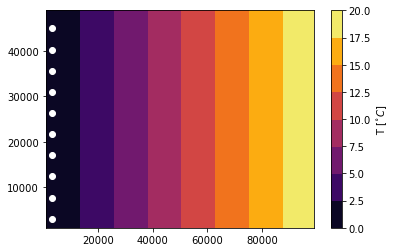

In [2]:
# Velocity and temperature fields
fieldset = FieldSet.from_parcels("Peninsula_data/peninsula", extra_fields={'T': 'T'}, allow_time_extrapolation=True)

# Particle locations and initial time
npart = 10  # number of particles to be released
lon = 3e3 * np.ones(npart)
lat = np.linspace(3e3 , 45e3, npart, dtype=np.float32)
time = np.arange(0, npart) * delta(hours=2).total_seconds()  # release each particle two hours later

# Plot temperature field and initial particle locations
T_data = xr.open_dataset("Peninsula_data/peninsulaT.nc")
plt.figure()
ax = plt.axes()
T_contour = ax.contourf(T_data.x.values, T_data.y.values, T_data.T.values[0,0], cmap=plt.cm.inferno)
ax.scatter(lon, lat, c='w')
plt.colorbar(T_contour, label='T [$^{\circ} C$]')
plt.show()

To sample the temperature field, we need to create a new class of particles where temperature is a `Variable`. As an argument for the `Variable` class, we need to provide the initial values for the particles. The easiest option is to access `fieldset.T`, but this option has some drawbacks.

In [3]:
class SampleParticle(JITParticle):         # Define a new particle class
    temperature = Variable('temperature', initial=fieldset.T)  # Variable 'temperature' initialised by sampling the temperature

pset = ParticleSet(fieldset=fieldset, pclass=SampleParticle, lon=lon, lat=lat, time=time)

Using `fieldset.T` leads to the `WARNING` displayed above because `Variable` accesses the fieldset in the slower SciPy mode. Another problem can occur when using the repeatdt argument instead of time:

<a id='repeatdt_error'></a>

In [4]:
repeatdt = delta(hours=3)

pset = ParticleSet(fieldset=fieldset, pclass=SampleParticle, lon=lon, lat=lat, repeatdt=repeatdt)

RuntimeError: Cannot initialise a Variable with a Field if no time provided. Add a "time=" to ParticleSet construction

Since the initial time is not defined, the `Variable` class does not know at what time to access the temperature field.

The solution to this initialisation problem is to leave the initial value zero and sample the initial condition in JIT mode with the sampling Kernel:

In [5]:
class SampleParticleInitZero(JITParticle):            # Define a new particle class
    temperature = Variable('temperature', initial=0)  # Variable 'temperature' initially zero

pset = ParticleSet(fieldset=fieldset, pclass=SampleParticleInitZero, lon=lon, lat=lat, time=time)

def SampleT(particle, fieldset, time):
         particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]
sample_kernel = pset.Kernel(SampleT)    # Casting the SampleT function to a kernel.

To sample the initial values we can execute the Sample kernel over the entire particleset with dt = 0 so that time does not increase

In [6]:
pset.execute(sample_kernel, dt=0) # by only executing the sample kernel we record the initial temperature of the particles

output_file = pset.ParticleFile(name="InitZero.nc", outputdt=delta(hours=1))
pset.execute(AdvectionRK4 + sample_kernel, runtime=delta(hours=30), dt=delta(minutes=5),
             output_file=output_file)
output_file.export()  # export the trajectory data to a netcdf file
output_file.close()

INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\95267e2b33bce749036c721bfb587691_0.dll
INFO: Compiled SampleParticleInitZeroAdvectionRK4SampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\7e5de9a8e76698139bc7c407a0d61d6f_0.dll


The particle dataset now contains the particle trajectories and the corresponding environmental temperature

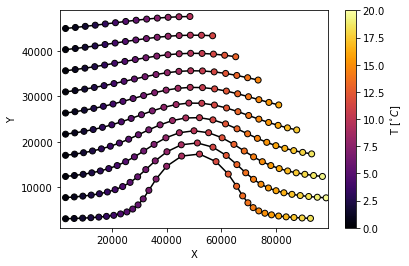

In [7]:
Particle_data = xr.open_dataset("InitZero.nc")

plt.figure()
ax = plt.axes()
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_ylim(1000, 49000)
ax.set_xlim(1000, 99000)
ax.plot(Particle_data.lon.transpose(), Particle_data.lat.transpose(), c='k', zorder=1)
T_scatter = ax.scatter(Particle_data.lon, Particle_data.lat, c=Particle_data.temperature, 
                       cmap=plt.cm.inferno, norm=mpl.colors.Normalize(vmin=0., vmax=20.), 
                       edgecolor='k', zorder=2)
plt.colorbar(T_scatter, label='T [$^{\circ} C$]')
plt.show()

### Sampling initial values

In some simulations only the particles initial value within the field is of interest: the variable does not need to be known along the entire trajectory. To reduce computing we can specify the `to_write` argument to the temperature `Variable`. This argument can have three values: `True`, `False` or `'once'`. It determines whether to write the `Variable` to the output file. If we want to know only the initial value, we can enter `'once'` and only the first value will be written to the output file.

In [8]:
class SampleParticleOnce(JITParticle):         # Define a new particle class
    temperature = Variable('temperature', initial=0, to_write='once')  # Variable 'temperature'
    
pset = ParticleSet(fieldset=fieldset, pclass=SampleParticleOnce, lon=lon, lat=lat, time=time)

In [9]:
pset.execute(sample_kernel, dt=0) # by only executing the sample kernel we record the initial temperature of the particles

output_file = pset.ParticleFile(name="WriteOnce.nc", outputdt=delta(hours=1))
pset.execute(AdvectionRK4, runtime=delta(hours=24), dt=delta(minutes=5),
             output_file=output_file)
output_file.close()

INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\a7be8026cea52a1209527ece608da439_0.dll
INFO: Compiled SampleParticleOnceAdvectionRK4 ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\a89daffb525400878a75fcf5f9700e46_0.dll


Since all the particles are released at the same x-position and the temperature field is invariant in the y-direction, all particles have an initial temperature of 0.4$^\circ$C

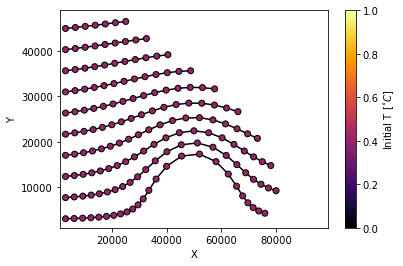

In [10]:
Particle_data = xr.open_dataset("WriteOnce.nc")

plt.figure()
ax = plt.axes()
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_ylim(1000, 49000)
ax.set_xlim(1000, 99000)
ax.plot(Particle_data.lon.transpose(), Particle_data.lat.transpose(), c='k', zorder=1)
T_scatter = ax.scatter(Particle_data.lon, Particle_data.lat, 
                       c=np.tile(Particle_data.temperature, (Particle_data.lon.shape[1], 1)).T,
                       cmap=plt.cm.inferno, norm=mpl.colors.Normalize(vmin=0., vmax=1.), 
                       edgecolor='k', zorder=2)
plt.colorbar(T_scatter, label='Initial T [$^{\circ} C$]')
plt.show()

### Sampling with repeatdt

Some experiments require large sets of particles to be released repeatedly on the same locations. The  [`particleset`](https://oceanparcels.org/gh-pages/html/#module-parcels.particleset) object has the option `repeatdt` for this, but when you want to sample the initial values this introduces some problems as we have seen [here](#repeatdt_error). For more advanced control over the repeated release of particles, you can manually write a for-loop using the function `particleset.add()`. Note that this for-loop is very similar to the one that  `repeatdt` would execute under the hood in `particleset.execute()`.

Adding particles to the `particleset` during the simulation reduces the memory used compared to specifying the delayed particle release times upfront, which improves the computational speed. In the loop, we want to initialise new particles and sample their initial temperature. If we want to write both the initialised particles with the sampled temperature and the older particles that have already been advected, we have to make sure both sets of particles find themselves at the same moment in time. The initial conditions must be written to the output file before advecting them, because during advection the `particle.time` will increase.

We do not specify the `outputdt` argument for the `output_file` and instead write the data with `output_file.write(pset, time)` on each iteration. A new particleset is initialised whenever time is a multiple of `repeatdt`. Because the particles are advected after being written, the last displacement must be written once more after the loop.

In [11]:
outputdt = delta(hours=1).total_seconds() # write the particle data every hour
repeatdt = delta(hours=6).total_seconds() # release each set of particles six hours later
runtime = delta(hours=24).total_seconds() 

pset = ParticleSet(fieldset=fieldset, pclass=SampleParticleInitZero, lon=[], lat=[], time=[]) # Using SampleParticleInitZero
kernels = AdvectionRK4 + sample_kernel

output_file = pset.ParticleFile(name="RepeatLoop.nc") # Do not specify the outputdt yet, so we can manually write the output

for time in np.arange(0, runtime, outputdt):
    if np.isclose(np.fmod(time, repeatdt), 0):    # time is a multiple of repeatdt
        pset_init = ParticleSet(fieldset=fieldset, pclass=SampleParticleInitZero, lon=lon, lat=lat, time=time)
        pset_init.execute(sample_kernel, dt=0)    # record the initial temperature of the particles
        pset.add(pset_init)                       # add the newly released particles to the total particleset
        
    output_file.write(pset,time)                  # write the initialised particles and the advected particles

    pset.execute(kernels, runtime=outputdt, dt=delta(minutes=5))
    print('Length of pset at time %d: %d' % (time, len(pset)))
    
output_file.write(pset, time+outputdt) 

output_file.close()

INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\d441e19c77676cd806da7f8e4c974550_0.dll
INFO: Compiled SampleParticleInitZeroAdvectionRK4SampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\d1281aa8d15fe9594b477ca71b782dce_0.dll


Length of pset: 10
Length of pset: 10
Length of pset: 10
Length of pset: 10
Length of pset: 10
Length of pset: 10


INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\01fc394199c11f84c25331b4797a64a0_0.dll


Length of pset: 20
Length of pset: 20
Length of pset: 20
Length of pset: 20
Length of pset: 20
Length of pset: 20


INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\1dcf704643338d59fe9815a88cd8967c_0.dll


Length of pset: 30
Length of pset: 30
Length of pset: 30
Length of pset: 30
Length of pset: 30
Length of pset: 30


INFO: Compiled SampleParticleInitZeroSampleT ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\0364537a5edb2a00eaf61893bcae1143_0.dll


Length of pset: 40
Length of pset: 40
Length of pset: 40
Length of pset: 40
Length of pset: 40
Length of pset: 40


In each iteration of the loop, spanning six hours, we have added ten particles.

In [12]:
Particle_data = xr.open_dataset("RepeatLoop.nc")
print(Particle_data.time[:,0].values / np.timedelta64(1, 'h')) # The initial hour at which each particle is released
assert np.allclose(Particle_data.time[:,0].values / np.timedelta64(1, 'h'), [int(k/10)*6 for k in range(40)])

[ 0  0  0  0  0  0  0  0  0  0  6  6  6  6  6  6  6  6  6  6 12 12 12 12
 12 12 12 12 12 12 18 18 18 18 18 18 18 18 18 18]


Let's check if the initial temperatures were sampled correctly for all particles

In [13]:
print(Particle_data.temperature[:,0].values)
assert np.allclose(Particle_data.temperature[:,0].values, Particle_data.temperature[:,0].values[0])

[0.4040816 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816
 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816
 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816
 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816
 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816
 0.4040816 0.4040816 0.4040816 0.4040816 0.4040816]


And see if the sampling of the temperature field is done correctly along the trajectories

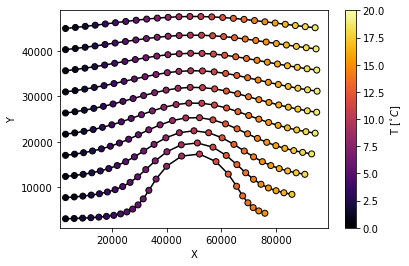

In [14]:
Release0 = Particle_data.where(Particle_data.time[:,0]==np.timedelta64(0, 's')) # the particles released at t = 0

plt.figure()
ax = plt.axes()
ax.set_ylabel('Y')
ax.set_xlabel('X')
ax.set_ylim(1000, 49000)
ax.set_xlim(1000, 99000)
ax.plot(Release0.lon.transpose(), Release0.lat.transpose(), c='k', zorder=1)
T_scatter = ax.scatter(Release0.lon, Release0.lat, c=Release0.temperature, 
                       cmap=plt.cm.inferno, norm=mpl.colors.Normalize(vmin=0., vmax=20.), 
                       edgecolor='k', zorder=2)
plt.colorbar(T_scatter, label='T [$^{\circ} C$]')
plt.show()